# Audio Retrieval
This notebooks demonstrates the process of the task and shows the results. 

## Task 1: Obtaining Data and Query Processing
We obtained the data from the MTG-Jamendo dataset. We used the 04 of the many tarballs available. The data can be downloaded [here](https://cdn.freesound.org/mtg-jamendo/raw_30s/audio/raw_30s_audio-04.tar). 

We randomly selected 20 tracks representing the query tracks. 
For each of the selected files, we extracted an approx. 10 sec segment starting at a random position within the first 20 seconds. We did this with other tools such as Audacity and FFmpeg (please see the folder `queries`for the corresponding .sh files used for automating the process).

We created differently distorted versions of the query tracks by applying the following transformations:
- Original: unmodified 10 sec segment
- Noise: added Gaussian noise to the segment
- Coding: compressed representation
- Mobile: outdoor recording with a mobile phone in an urban setting

The query tracks with the transformations are stored in the `queries` folder.
The MTG-Jamendo dataset provides mp3 files. We convert all `.mp3` files to `.wav` format because `.wav` provides lossless audio quality, ensuring more accurate spectrogram generation and audio analysis.

As a first step in this notebook. Let's create 2 methods to load the query and the data files.

In [108]:
import os

def get_files(directory='../data', endswith='.wav'):
    files = []
    for root, _, fs in os.walk(directory):
        for f in fs:
            if f.endswith(endswith):
                files.append(os.path.join(root, f))
    return files

In [109]:
print(get_files('../data/04', endswith='.mp3'))

['../data/04/1143804.mp3', '../data/04/1302604.mp3', '../data/04/1178104.mp3', '../data/04/37804.mp3', '../data/04/1336204.mp3', '../data/04/1166104.mp3', '../data/04/229604.mp3', '../data/04/1397804.mp3', '../data/04/810904.mp3', '../data/04/1314304.mp3', '../data/04/1210604.mp3', '../data/04/225604.mp3', '../data/04/25804.mp3', '../data/04/1170404.mp3', '../data/04/1032804.mp3', '../data/04/1132804.mp3', '../data/04/80704.mp3', '../data/04/1326604.mp3', '../data/04/950104.mp3', '../data/04/1125404.mp3', '../data/04/1396104.mp3', '../data/04/1121104.mp3', '../data/04/152804.mp3', '../data/04/28104.mp3', '../data/04/1157904.mp3', '../data/04/1079804.mp3', '../data/04/1345604.mp3', '../data/04/1341304.mp3', '../data/04/1288104.mp3', '../data/04/1083604.mp3', '../data/04/1183604.mp3', '../data/04/564204.mp3', '../data/04/1349604.mp3', '../data/04/1300204.mp3', '../data/04/285504.mp3', '../data/04/1391904.mp3', '../data/04/433604.mp3', '../data/04/1150104.mp3', '../data/04/891604.mp3', '.

## Task 2: Database Preparation
For this task, we will create constellation maps for the first 30 seconds of each track in the database. The steps include:

1. Loading the first 30 seconds of audio files.
2. Computing the spectrograms using Short-Time Fourier Transform (STFT).
3. Generating constellation maps with different configurations for neighborhood parameters (`κ`, `τ`).
4. Storing the results in memory and optionally saving them to disk.

First let's define a helper method to compute and plot the constellation maps and compute the spectrogram.

In [90]:
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

import libfmp.b
import libfmp.c2
import libfmp.c6


# Function to compute constellation map
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im
    
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    #x, Fs = librosa.load(fn_wav, Fs)
    x, Fs = librosa.load(fn_wav, sr=Fs, duration=30)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y
 

We will process the following configurations for the constellation map:

- `(κ=5, τ=3)`
- `(κ=7, τ=7)`
- `(κ=10, τ=5)`
- `(κ=15, τ=10)`

The files will be loaded from the folder `../data/04`.

In [91]:
# Example configurations
configurations = [
    (8, 2),  # (κ=8, τ=2)
    (11, 3),  # (κ=11, τ=3)
    (15, 4), # (κ=15, τ=4)
    (17, 5),  # (κ=17, τ=5)
]

# File list for processing
file_list = get_files(directory='../data/04', endswith=".mp3")

We will compute constellation maps for each file and configuration and store the results in memory. Optionally, the maps can be saved as `.npz` files for later use.

In [92]:
def prepare_database(file_list, configurations, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    database = {}

    for file in file_list:
        print(f"Processing file: {file}...")

        # Compute spectrogram for the current file
        Y = compute_spectrogram(file, Fs=Fs, N=N, H=H, bin_max=bin_max, frame_max=frame_max)

        # Retrieve metadata for the file
        file_size = os.path.getsize(file)  # Size in bytes
        duration = librosa.get_duration(path=file)  # Duration in seconds

        # Initialize nested structure for the current file
        file_key = os.path.basename(file)
        database[file_key] = {
            "metadata": {
                "size": file_size,
                "name_without_extension": os.path.splitext(file_key)[0],
            },
            "constellation_maps": {}
        }

        # Compute constellation maps for all configurations
        for (dist_freq, dist_time) in configurations:
            cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
            database[file_key]["constellation_maps"][(dist_freq, dist_time)] = cmap

    return database


# Prepare database
database = prepare_database(file_list, configurations)

Processing file: ../data/04/1143804.mp3...
Processing file: ../data/04/1302604.mp3...
Processing file: ../data/04/1178104.mp3...
Processing file: ../data/04/37804.mp3...
Processing file: ../data/04/1336204.mp3...
Processing file: ../data/04/1166104.mp3...
Processing file: ../data/04/229604.mp3...
Processing file: ../data/04/1397804.mp3...
Processing file: ../data/04/810904.mp3...
Processing file: ../data/04/1314304.mp3...
Processing file: ../data/04/1210604.mp3...
Processing file: ../data/04/225604.mp3...
Processing file: ../data/04/25804.mp3...
Processing file: ../data/04/1170404.mp3...
Processing file: ../data/04/1032804.mp3...
Processing file: ../data/04/1132804.mp3...
Processing file: ../data/04/80704.mp3...
Processing file: ../data/04/1326604.mp3...
Processing file: ../data/04/950104.mp3...
Processing file: ../data/04/1125404.mp3...
Processing file: ../data/04/1396104.mp3...
Processing file: ../data/04/1121104.mp3...
Processing file: ../data/04/152804.mp3...
Processing file: ../da

We will visualize the constellation maps for the first file (with all the configurations) in the database. Each constellation map will show:

1. The spectrogram of the audio.
2. The detected peaks for one selected configuration.

This will help us verify that the constellation maps are being computed correctly.

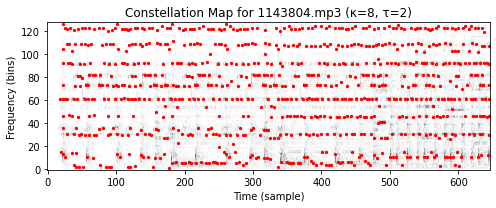

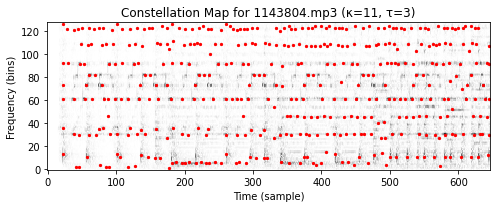

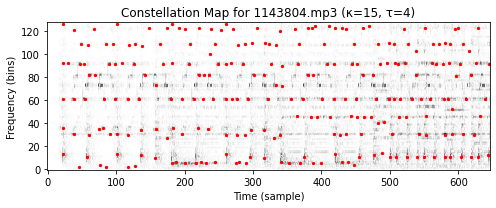

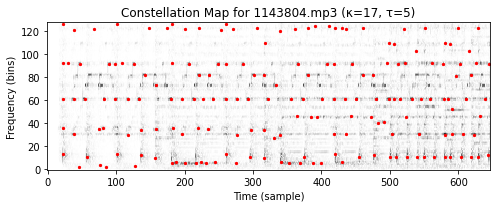

In [93]:
# Display constellation maps for the first file with all configurations
first_file = file_list[0]

# Compute the spectrogram for the first file
Y = compute_spectrogram(first_file, Fs=22050, N=2048, H=1024, bin_max=128)

# Plot constellation maps for all configurations
for dist_freq, dist_time in configurations:
    cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
    title = f"Constellation Map for {os.path.basename(first_file)} (κ={dist_freq}, τ={dist_time})"
    plot_constellation_map(cmap, Y=Y, title=title)


The generated constellation maps can be saved to disk for later use. Each map will be stored as an `.npz` file. (Optional)


In [94]:
output_folder = "constellations"
os.makedirs(output_folder, exist_ok=True)

for key, cmap in database.items():
    np.savez_compressed(os.path.join(output_folder, f"{key}.npz"), cmap=cmap)

print(f"Saved constellation maps to {output_folder}")


Saved constellation maps to constellations


## Task 3: Retrieval Experimentation
In this section, we perform retrieval experiments by:

1. Calculating constellation maps for the queries created in Task 1.
2. Comparing each query's constellation map with all maps in the database.
3. Identifying the best match by sliding the query constellation map over each database map and calculating the overlap.
4. Evaluating the performance of the retrieval system using true positives (TP), false positives (FP), and false negatives (FN).
5. Analyzing the impact of different tolerance settings (`tol_freq`, `tol_time`) and configurations (`κ`, `τ`).

The final results include:
- The file(s) with the highest match scores.
- Average query processing time.
- A table comparing performance metrics for various configurations and query distortions.

First again, let's define some helper methods to perform the retrieval experiments.

Important: 
We chose the F-measure to determine the best match position because it provides a balanced evaluation by combining precision and recall. This metric ensures that the matching function considers both the accuracy of the matches (precision) and the completeness of identifying all relevant matches (recall), which is critical for robust and fair comparisons across different constellation maps.



In [95]:
def compute_matching_function(C_D, C_Q, tol_freq=1, tol_time=1):
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    assert M >= 0, "Query must be shorter than document"
    Delta = np.zeros(L)
    for m in range(M + 1):
        C_D_crop = C_D[:, m:m+N]
        TP, FN, FP, C_AND = match_binary_matrices_tol(C_D_crop, C_Q, tol_freq=tol_freq, tol_time=tol_time)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        Delta[m] = score
    shift_max = np.argmax(Delta)
    return Delta, shift_max


def match_binary_matrices_tol(C_ref, C_est, tol_freq=0, tol_time=0):
    assert C_ref.shape == C_est.shape, "Dimensions need to agree"
    N = np.sum(C_ref)
    M = np.sum(C_est)
    # Expand C_est with 2D-max-filter using the tolerance parameters
    C_est_max = ndimage.maximum_filter(C_est, size=(2*tol_freq+1, 2*tol_time+1),
                                       mode='constant')
    C_AND = np.logical_and(C_est_max, C_ref)
    TP = np.sum(C_AND)
    FN = N - TP
    FP = M - TP
    return TP, FN, FP, C_AND


First let's create the constellation maps for the query files. We will use the same configurations as before.

In [96]:
def prepare_query_constellation_maps(file_list, configurations, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    query_maps = {}

    for file in file_list:
        print(f"Processing file: {file}...")

        # Compute spectrogram for the current file
        Y = compute_spectrogram(file, Fs=Fs, N=N, H=H, bin_max=bin_max, frame_max=frame_max)

        # Retrieve metadata for the file
        file_size = os.path.getsize(file)  # Size in bytes
        
        # Initialize nested structure for the current query
        file_key = os.path.basename(file)
        query_maps[file_key] = {
            "metadata": {
                "size": file_size,
                "name_without_extension": file_key.split('_')[0],
            },
            "constellation_maps": {}
        }

        # Compute constellation maps for all configurations
        for (dist_freq, dist_time) in configurations:
            cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
            query_maps[file_key]["constellation_maps"][(dist_freq, dist_time)] = cmap

    return query_maps

query_list_original = get_files(directory='../queries/cut_output', endswith=".wav")
query_list_noise = get_files(directory='../queries/noise_output', endswith=".wav")
query_list_coding = get_files(directory='../queries/coding_output', endswith=".wav")
query_list_mobile = get_files(directory='../queries/mobile_output', endswith=".wav")

query_C_original = prepare_query_constellation_maps(query_list_original, configurations)
query_C_noise = prepare_query_constellation_maps(query_list_noise, configurations)
query_C_coding = prepare_query_constellation_maps(query_list_coding, configurations)
query_C_mobile = prepare_query_constellation_maps(query_list_mobile, configurations)

print(query_C_original.keys())


Processing file: ../queries/cut_output/903604_cut.wav...
Processing file: ../queries/cut_output/1009604_cut.wav...
Processing file: ../queries/cut_output/1247404_cut.wav...
Processing file: ../queries/cut_output/1415804_cut.wav...
Processing file: ../queries/cut_output/1299504_cut.wav...
Processing file: ../queries/cut_output/1092304_cut.wav...
Processing file: ../queries/cut_output/1132204_cut.wav...
Processing file: ../queries/cut_output/1121404_cut.wav...
Processing file: ../queries/cut_output/1165404_cut.wav...
Processing file: ../queries/cut_output/1042004_cut.wav...
Processing file: ../queries/cut_output/1270604_cut.wav...
Processing file: ../queries/cut_output/863504_cut.wav...
Processing file: ../queries/cut_output/390004_cut.wav...
Processing file: ../queries/cut_output/1319504_cut.wav...
Processing file: ../queries/cut_output/1227104_cut.wav...
Processing file: ../queries/cut_output/1281204_cut.wav...
Processing file: ../queries/cut_output/3904_cut.wav...
Processing file: ../

Now, let's do a test for the first query file to the first database file. (3904)

In [97]:
Delta, shiftmax = compute_matching_function(database["3904.mp3"]["constellation_maps"][(8, 2)], query_C_original["3904_cut.wav"]["constellation_maps"][(8, 2)])

print(f'maximal value of 2 matching queries: {Delta[shiftmax]}')

Delta, shiftmax = compute_matching_function(database["1121404.mp3"]["constellation_maps"][(8, 2)], query_C_original["3904_cut.wav"]["constellation_maps"][(8, 2)])

print(f'maximal value of 2 non matching queries: {Delta[shiftmax]}')

Delta, shiftmax = compute_matching_function(database["7204.mp3"]["constellation_maps"][(8, 2)], query_C_original["3904_cut.wav"]["constellation_maps"][(8, 2)])

print(f'maximal value of 2 non matching queries: {Delta[shiftmax]}')

maximal value of 2 matching queries: 225.0
maximal value of 2 non matching queries: 58.0
maximal value of 2 non matching queries: 60.0


This shows us that the matching function is working. Now let's check how fast it is to evaluate one query against all the database files.



In [107]:
import time

def evaluate_query(Q_C, database, configuration, tol_freq=1, tol_time=1):
    """
    Evaluates a query against a database using a specific constellation map configuration.

    Args:
        Q_C (numpy.ndarray): Query constellation map.
        database (dict): Database containing constellation maps and metadata.
        configuration (tuple): (dist_freq, dist_time) configuration to use for matching.

    Returns:
        tuple: Top result as a tuple (database_key, matching_score).
        float: Elapsed time in seconds for the evaluation.
    """
    start_time = time.time()
    
    top_result = None
    top_score = -1
    i = 0
    for database_key, database_data in database.items():
        i += 1
        D_C = database_data["constellation_maps"][configuration]
        
        Delta, shift_max = compute_matching_function(D_C, Q_C, tol_freq, tol_time)
        score = Delta[shift_max]
        
        if score > top_score:
            top_score = score
            top_result = (database_key, score)

    #print(f'Processed {i} files')
    elapsed_time = time.time() - start_time

    return top_result, elapsed_time

result, time = evaluate_query(query_C_original["3904_cut.wav"]["constellation_maps"][(8, 2)], database, (8, 2))

print(f'Retrieved top result: {result} in {time} seconds')

Retrieved top result: ('3904.mp3', 225.0) in 44.526658058166504 seconds


Perfect, the evaluation is working. Of course the best overlap is identified by sliding the query constellation map sample-by-sample over each constellation map
in the database. This is a very time-consuming process, but for now we will work with this approach to perform retrieval experiments: 

First of all, let's evaluate all original queries (10sec, unmodified) against the database with all configurations. For each query we want to record the time it took, and we want to see if the correct music piece is retrieved. Then for all the distorted/transformed queries we also want to record time and hit (miss) rate. By doing this we can compare different configurations of κ and τ (i.e, dist_freq and dist_time, resp.). 

Additionally, we want to redo the evaluation with different tolerance values (tol_freq and tol_time) to see how this affects the retrieval performance.

We chose to record the results in a csv file for persistence.   

In [106]:
import csv
import time

def evaluate_queries(query_constellation_maps, database, configuration, tol_freq, tol_time, output_file):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Query", "Configuration", "Tolerance", "Hit", "Time (s)"])
        for query_key, query_data in query_constellation_maps.items():
            Q_C = query_data["constellation_maps"][configuration]
            result, elapsed_time = evaluate_query(Q_C, database, configuration)
            identifier = database[result[0]]["metadata"]["name_without_extension"]
            hit = 1 if identifier == query_constellation_maps[query_key]["metadata"]["name_without_extension"] else 0
            writer.writerow([query_key, configuration, (tol_freq, tol_time), hit, elapsed_time])
            
for configuration in configurations:
    evaluate_queries(query_C_original, database, configuration, 0, 0, f"results_original_{configuration}.csv")
    print(f"Results original for configuration {configuration} saved.")
    evaluate_queries(query_C_noise, database, configuration, 0, 0, f"results_noise_{configuration}.csv")
    print(f"Results noise for configuration {configuration} saved.")
    evaluate_queries(query_C_coding, database, configuration, 0, 0, f"results_coding_{configuration}.csv")
    print(f"Results coding for configuration {configuration} saved.")
    #evaluate_queries(query_C_mobile, database, configuration, 1, 1, f"results_mobile_{configuration}.csv")